## ThinkDSP

This notebook contains an implementation of an algorithm to generate pink noise.

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [ ]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

## Generating pink noise

The Voss algorithm is described in this paper:

Voss, R. F., & Clarke, J. (1978). "1/f noise" in music: Music from 1/f noise". *Journal of the Acoustical Society of America* 63: 258–263. Bibcode:1978ASAJ...63..258V. doi:10.1121/1.381721.

And presented by Martin Gardner in this *Scientific American* article:

Gardner, M. (1978). "Mathematical Games—White and brown music, fractal curves and one-over-f fluctuations". *Scientific American* 238: 16–32.

McCartney suggested an improvement here:

http://www.firstpr.com.au/dsp/pink-noise/

And Trammell proposed a stochastic version here:

http://home.earthlink.net/~ltrammell/tech/pinkalg.htm

The fundamental idea of this algorithm is to add up several sequences of random numbers that get updated at different rates.  The first source should get updated at every time step; the second source every other time step, the third source ever fourth step, and so on.

In the original algorithm, the updates are evenly spaced.  In the stochastic version, they are randomly spaced.

My implementation starts with an array with one row per timestep and one column for each of the white noise sources.  Initially, the first row and the first column are random and the rest of the array is Nan.

In [31]:
nrows = 100
ncols = 5

array = np.full((nrows, ncols), np.nan)
array[0, :] = np.random.random(ncols)
array[:, 0] = np.random.random(nrows)
array[0:6]

array([[0.57860087, 0.08307124, 0.42265839, 0.59811563, 0.11750404],
       [0.88739308,        nan,        nan,        nan,        nan],
       [0.02397037,        nan,        nan,        nan,        nan],
       [0.88304887,        nan,        nan,        nan,        nan],
       [0.94614767,        nan,        nan,        nan,        nan],
       [0.87177779,        nan,        nan,        nan,        nan]])

The next step is to choose the locations where the random sources change.  If the number of rows is $n$, the number of changes in the first column is $n$, the number in the second column is $n/2$ on average, the number in the third column is $n/4$ on average, etc.

So the total number of changes in the matrix is $2n$ on average; since $n$ of those are in the first column, the other $n$ are in the rest of the matrix.

To place the remaining $n$ changes, we generate random columns from a geometric distribution with $p=0.5$.  If we generate a value out of bounds, we set it to 0 (so the first column gets the extras).

In [32]:
p = 0.5
n = nrows
cols = np.random.geometric(p, n)
cols[cols >= ncols] = 0
cols

array([3, 2, 1, 2, 1, 2, 1, 3, 2, 1, 2, 1, 2, 2, 1, 1, 1, 3, 2, 2, 1, 2,
       2, 3, 0, 2, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 1, 3, 3, 1, 3, 1, 2, 1,
       1, 3, 4, 1, 0, 1, 1, 1, 1, 2, 3, 1, 1, 3, 2, 2, 1, 1, 1, 0, 3, 1,
       4, 3, 1, 2, 1, 1, 3, 1, 1, 1, 1, 3, 4, 1, 1, 1, 0, 3, 1, 1, 1, 1,
       1, 1, 1, 3, 3, 1, 1, 0, 3, 1, 1, 1])

Within each column, we choose a random row from a uniform distribution.  Ideally we would choose without replacement, but it is faster and easier to choose with replacement, and I doubt it matters.

In [33]:
rows = np.random.randint(nrows, size=n)
rows

array([34, 68, 13, 35, 54, 15, 33, 20, 51, 73, 20, 21, 66, 21, 72, 74, 99,
       26, 92, 70, 71, 43, 88,  6, 16, 89, 54, 51,  7, 10, 83, 62, 89,  3,
       44, 19, 95, 40, 69, 57, 97, 62, 99,  5, 91,  3,  1, 42, 66, 17, 50,
       16, 54, 70, 92, 12, 25, 13, 10,  9, 11, 47, 16, 21, 73, 71, 92, 66,
       79, 96, 50, 18, 95, 89, 85, 82, 59, 48, 65, 95, 48, 40, 60, 64, 40,
       68, 68, 77, 74, 84, 77, 19, 73, 99, 20, 61, 59, 68, 93, 40])

Now we can put random values at rach of the change points.

In [34]:
array[rows, cols] = np.random.random(n)
array[0:6]

array([[0.57860087, 0.08307124, 0.42265839, 0.59811563, 0.11750404],
       [0.88739308,        nan,        nan,        nan, 0.39716012],
       [0.02397037,        nan,        nan,        nan,        nan],
       [0.42140748,        nan,        nan, 0.91534844,        nan],
       [0.94614767,        nan,        nan,        nan,        nan],
       [0.87177779, 0.35675871,        nan,        nan,        nan]])

Next we want to do a zero-order hold to fill in the NaNs.  NumPy doesn't do that, but Pandas does.  So I'll create a DataFrame:

In [35]:
import pandas as pd

df = pd.DataFrame(array)
df.head()

,0,1,2,3,4
0,0.578601,0.083071,0.422658,0.598116,0.117504
1,0.887393,NaN,NaN,NaN,0.397160
2,0.023970,NaN,NaN,NaN,NaN
3,0.421407,NaN,NaN,0.915348,NaN
4,0.946148,NaN,NaN,NaN,NaN


And then use `fillna` along the columns.

In [36]:
filled = df.fillna(method='ffill', axis=0)
filled.head()

,0,1,2,3,4
0,0.578601,0.083071,0.422658,0.598116,0.117504
1,0.887393,0.083071,0.422658,0.598116,0.397160
2,0.023970,0.083071,0.422658,0.598116,0.397160
3,0.421407,0.083071,0.422658,0.915348,0.397160
4,0.946148,0.083071,0.422658,0.915348,0.397160


Finally we add up the rows.

In [37]:
total = filled.sum(axis=1)
total.head()

0    1.799950
1    2.388398
2    1.524976
3    2.239646
4    2.764386
dtype: float64

If we put the results into a Wave, here's what it looks like:

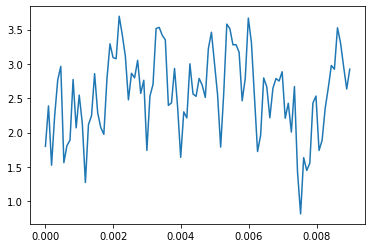

In [39]:
from thinkdsp import Wave

wave = Wave(total)
wave.plot()

Here's the whole process in a function:

In [40]:
def voss(nrows, ncols=16):
    """Generates pink noise using the Voss-McCartney algorithm.
    
    nrows: number of values to generate
    rcols: number of random sources to add
    
    returns: NumPy array
    """
    array = np.full((nrows, ncols), np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

To test it I'll generate 11025 values:

In [41]:
ys = voss(11025)
ys

array([7.15173107, 7.29397747, 6.06096927, ..., 8.28577774, 7.91418078,
       8.13263103])

And make them into a Wave:

In [42]:
wave = Wave(ys)
wave.unbias()
wave.normalize()

Here's what it looks like:

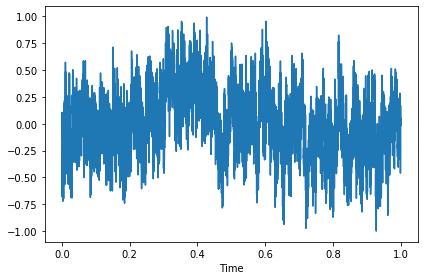

In [43]:
wave.plot()
decorate(xlabel='Time')

As expected, it is more random-walk-like than white noise, but more random looking than red noise.

Here's what it sounds like:

In [44]:
wave.make_audio()

And here's the power spectrum:

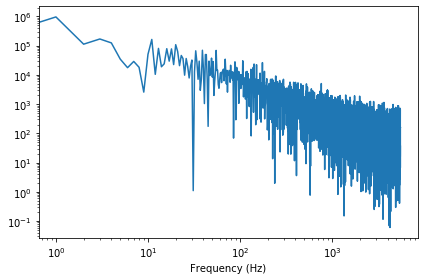

In [46]:
spectrum = wave.make_spectrum()
spectrum.hs[0] = 0
spectrum.plot_power()
decorate(xlabel='Frequency (Hz)',
         xscale='log', 
         yscale='log')

The estimated slope is close to -1.

In [47]:
spectrum.estimate_slope().slope

-1.0100527043087335

We can get a better sense of the average power spectrum by generating a longer sample:

In [48]:
seg_length = 64 * 1024
iters = 100
wave = Wave(voss(seg_length * iters))
len(wave)

6553600

And using Barlett's method to compute the average.

In [49]:
from thinkdsp import Spectrum

def bartlett_method(wave, seg_length=512, win_flag=True):
    """Estimates the power spectrum of a noise wave.
    
    wave: Wave
    seg_length: segment length
    """
    # make a spectrogram and extract the spectrums
    spectro = wave.make_spectrogram(seg_length, win_flag)
    spectrums = spectro.spec_map.values()
    
    # extract the power array from each spectrum
    psds = [spectrum.power for spectrum in spectrums]
    
    # compute the root mean power (which is like an amplitude)
    hs = np.sqrt(sum(psds) / len(psds))
    fs = next(iter(spectrums)).fs
    
    # make a Spectrum with the mean amplitudes
    spectrum = Spectrum(hs, fs, wave.framerate)
    return spectrum

In [50]:
spectrum = bartlett_method(wave, seg_length=seg_length, win_flag=False)
spectrum.hs[0] = 0
len(spectrum)

32769

It's pretty close to a straight line, with some curvature at the highest frequencies.

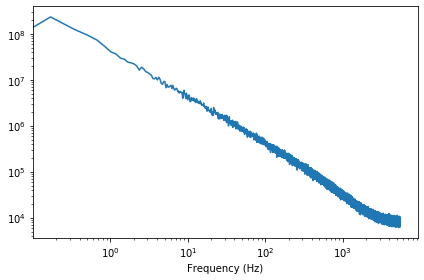

In [51]:
spectrum.plot_power()
decorate(xlabel='Frequency (Hz)',
                 xscale='log', 
                 yscale='log')

And the slope is close to -1.

In [52]:
spectrum.estimate_slope().slope

-1.0014059496815706